## Research Paper Answer Bot

## Install OpenAI, and LangChain dependencies

In [12]:
%%capture
!pip install langchain==0.3.11
!pip install langchain-openai==0.2.12
!pip install langchain-community==0.3.11
!pip install langchain-chroma==0.1.4

In [11]:
! pip install openai


In [10]:
%%capture
!pip install langchain-huggingface==0.1.2

In [13]:
%%capture
!pip install -U sentence-transformers


In [3]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [5]:
from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = getpass('Enter HuggingFace Auth Token Key: ')

In [6]:
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HUGGINGFACEHUB_API_TOKEN

## LOAD DATA FILES 

In [7]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader

# Adjust the path to your directory
directory_path = "/Users/spoorthiramireddygari/Desktop/Introduction to LangChain - Building Generative AI Apps & Agents/Assignment /pinnacle_capstone_data"
loader = DirectoryLoader(directory_path, glob="**/*.pdf", loader_cls=PyPDFLoader)
documents = loader.load()
print(f"Loaded {len(documents)} pages/documents")


Loaded 95 pages/documents


In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Function to test different chunk sizes
def test_chunk_sizes(documents, chunk_sizes, chunk_overlap):
    results = {}
    for size in chunk_sizes:
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=size, chunk_overlap=chunk_overlap)
        doc_chunks = text_splitter.split_documents(documents)
        results[size] = len(doc_chunks)
        print(f"Chunk Size: {size} | Created {len(doc_chunks)} chunks from {len(documents)} pages")
    return results

# Test different chunk sizes
chunk_sizes_to_test = [400, 650, 800, 1000]
chunk_overlap = 100  # Keep overlap consistent
test_results = test_chunk_sizes(documents, chunk_sizes_to_test, chunk_overlap)


Chunk Size: 400 | Created 1006 chunks from 95 pages
Chunk Size: 650 | Created 576 chunks from 95 pages
Chunk Size: 800 | Created 456 chunks from 95 pages
Chunk Size: 1000 | Created 366 chunks from 95 pages


In [67]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Configure the splitter parameters; adjust chunk_size and chunk_overlap based on your model's context window.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=750, chunk_overlap=100)
doc_chunks = text_splitter.split_documents(documents)
print(f"Created {len(doc_chunks)} chunks from your {len(documents)} pages")

Created 488 chunks from your 95 pages


In [ ]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import openai



# Function for Hugging Face models
def get_hf_embedding(text, model_name):
    # Load the tokenizer and model (ideally, do this outside the loop in production)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # For simplicity, use mean pooling
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    response = openai.Embedding.create(
        model=model,
        input=[text]
    )
    embedding = response['data'][0]['embedding']
    return embedding

# Define candidate models and corresponding functions
candidate_models = {
    "BGE-large-en-v1.5": lambda text: get_hf_embedding(text, "BAAI/bge-large-en-v1.5"),
    # "GTE-large": lambda text: get_hf_embedding(text, "Alibaba-NLP/gte-large-en-v1"),
    "UAE-large": lambda text: get_hf_embedding(text, "WhereIsAI/UAE-Large-V1"),
    "OpenAI embedding small": lambda text: get_embedding(text, model="text-embedding-3-small"),
    "OpenAI embedding large": lambda text: get_embedding(text, model="text-embedding-3-large"),
    "OpenAI ada": lambda text: get_embedding(text, model="text-embedding-ada-002"),
}


In [20]:
# Assuming each document chunk is a dictionary with the key 'text'
# first_5_chunks = [doc['text'] for doc in doc_chunks[:5]]
# Extract the text from each Document object
first_5_chunks = [doc.page_content for doc in doc_chunks[:5]]


performance_results = {}

# Evaluate each candidate on the first 5 chunks
for model_name, embed_func in candidate_models.items():
    start_time = time.time()
    embeddings = [embed_func(chunk) for chunk in first_5_chunks]
    elapsed = time.time() - start_time
    performance_results[model_name] = elapsed
    print(f"{model_name}: {elapsed:.2f} seconds for 5 chunks")

# Select the model with the lowest processing time
best_model = min(performance_results, key=performance_results.get)
print(f"\nSelected best model based on performance: {best_model}")

# Assign for further use:
assigned_embedding_model = best_model

BGE-large-en-v1.5: 7.37 seconds for 5 chunks
UAE-large: 7.38 seconds for 5 chunks
OpenAI embedding small: 2.56 seconds for 5 chunks
OpenAI embedding large: 3.16 seconds for 5 chunks
OpenAI ada: 0.81 seconds for 5 chunks

Selected best model based on performance: OpenAI ada


In [69]:
import chromadb

# Initialize ChromaDB client
chroma_client = chromadb.PersistentClient(path="./chroma_db")  # Saves data persistently
# Use InMemoryClient() if you don't want persistence

# Create or load a collection (like a table in a database)
collection = chroma_client.get_or_create_collection(name="rag_collection")

In [70]:
# Alternative batch approach
texts = [chunk.page_content for chunk in doc_chunks]
batch_embeddings = embeddings.embed_documents(texts)

for i, (chunk, embedding) in enumerate(zip(doc_chunks, batch_embeddings)):
    collection.add(
        ids=[str(i)],
        embeddings=[embedding],
        metadatas=[{"source": f"page_{i}"}],
        documents=[chunk.page_content],
    )

In [71]:
# 2. Query function
def ask_question(question, collection, max_results=3):
    # Generate embedding for the question
    query_embedding = embeddings.embed_query(question)
    
    # Search the database
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=max_results,
        include=["documents", "metadatas", "distances"]
    )
    
    # Print results
    print(f"\nQuestion: {question}")
    for i, (doc, meta, distance) in enumerate(zip(results['documents'][0], 
                                                results['metadatas'][0], 
                                                results['distances'][0])):
        print(f"\nResult {i+1}:")
        print(f"Source: {meta['source']}")
        print(f"Similarity Score: {1 - distance:.2f}")  # 1-distance = cosine similarity
        print(f"Content: {doc[:200]}...")  # Show first 200 characters

# 3. Test your RAG system
ask_question("What is the architecture of the Transformer model in intructgpt paper?", collection)
ask_question("Tell me about mistral paper in brief ", collection)


Question: What is the architecture of the Transformer model in intructgpt paper?

Result 1:
Source: page_168
Similarity Score: 0.70
Content: Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, ...

Result 2:
Source: page_166
Similarity Score: 0.65
Content: End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-
aligned recurrence and have been shown to perform well on simple-language question answering and
language m...

Result 3:
Source: page_163
Similarity Score: 0.65
Content: tion models in various tasks, allowing modeling of dependencies without regard to their distance in
the input or output sequences [2, 19]. In all but a few cases [27], however, such attention mechanis...

Question: Tell me about mistral paper in brief 

Result 1:
Source: page_5
Similarity Score: 0.66
Content: Mistral 7B is relea

In [68]:
# #(Optional) Delete and Reset Collection - If you need to delete and reset your vector database:
chroma_client.delete_collection(name="rag_collection")


## Ensemble Reteiver 


In [76]:
from langchain.retrievers import EnsembleRetriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.embeddings import OpenAIEmbeddings


In [77]:
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Wrap the ChromaDB collection in a LangChain retriever
vectorstore = Chroma(
    client=chroma_client,  # Your ChromaDB client
    collection_name="rag_collection",  # Your collection name
    embedding_function=OpenAIEmbeddings(model="text-embedding-ada-002")  # Your embedding function
)

# Create a similarity-based retriever
similarity_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [78]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import EmbeddingsFilter

# Define a filter for the compression retriever
embeddings_filter = EmbeddingsFilter(embeddings=OpenAIEmbeddings(model="text-embedding-ada-002"), similarity_threshold=0.7)

# Create a compression retriever
compression_retriever = ContextualCompressionRetriever(
    base_compressor=embeddings_filter,
    base_retriever=similarity_retriever
)

In [79]:
from langchain.retrievers import EnsembleRetriever

# Create the ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[compression_retriever, similarity_retriever],
    weights=[0.6, 0.3]  # Adjust weights based on importance
)

In [80]:
query = "What is the architecture of the Transformer model?"

# Retrieve documents using the ensemble retriever
results = ensemble_retriever.invoke(query)

# Print the results
for i, doc in enumerate(results):
    print(f"Document {i+1}:")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")
    print("-" * 50)

Document 1:
Content: Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively.
3.1 Encoder and Decoder Stacks
Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-
wise fully connected feed-forward network. We employ a residual connection [11] around each of
the two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is
Metadata: {'source': 'page_168'}
--------------------------------------------------
Document 2:
Content: End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-
aligned recurrence and have been shown to perform well on simple-language question answering and
langu

## Hybrid Search Retreiver

In [81]:
%%capture
!pip install langchain chromadb rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [82]:
# Create a dense retriever i.e similarity based retriever
dense_retriever = similarity_retriever

In [83]:
from rank_bm25 import BM25Okapi
from langchain.schema import Document

# Extract text from document chunks
texts = [doc.page_content for doc in doc_chunks]

# Tokenize the texts (split into words)
tokenized_texts = [text.split() for text in texts]

# Initialize BM25
bm25 = BM25Okapi(tokenized_texts)

# Create a sparse retriever
def sparse_retriever(query, top_k=5):
    tokenized_query = query.split()
    scores = bm25.get_scores(tokenized_query)
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
    return [doc_chunks[i] for i in top_indices]

In [84]:
def hybrid_search(query, dense_retriever, sparse_retriever, top_k=5):
    # Step 1: Retrieve documents using dense retrieval
    dense_results = dense_retriever.get_relevant_documents(query)
    
    # Step 2: Retrieve documents using sparse retrieval
    sparse_results = sparse_retriever(query, top_k=top_k)
    
    # Step 3: Combine and rerank results using RRF
    combined_results = reciprocal_rank_fusion(dense_results, sparse_results)
    
    return combined_results[:top_k]  # Return top-k results

In [85]:
def reciprocal_rank_fusion(dense_results, sparse_results, k=60):
    """
    Combine ranked lists using Reciprocal Rank Fusion (RRF).
    
    Args:
        dense_results: Ranked list from dense retrieval.
        sparse_results: Ranked list from sparse retrieval.
        k: A constant (typically 60) to control the influence of lower-ranked documents.
    
    Returns:
        list: Combined and reranked documents.
    """
    # Create a dictionary to store document scores
    scores = {}
    
    # Assign scores based on dense retrieval ranks
    for rank, doc in enumerate(dense_results):
        doc_id = doc.metadata["source"]  # Use a unique identifier for each document
        scores[doc_id] = scores.get(doc_id, 0) + 1 / (k + rank + 1)
    
    # Assign scores based on sparse retrieval ranks
    for rank, doc in enumerate(sparse_results):
        doc_id = doc.metadata["source"]  # Use a unique identifier for each document
        scores[doc_id] = scores.get(doc_id, 0) + 1 / (k + rank + 1)
    
    # Sort documents by their combined scores
    sorted_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    # Retrieve the full document objects
    combined_results = []
    for doc_id, _ in sorted_docs:
        # Find the document in either dense or sparse results
        doc = next((doc for doc in dense_results if doc.metadata["source"] == doc_id), None)
        if doc is None:
            doc = next((doc for doc in sparse_results if doc.metadata["source"] == doc_id), None)
        if doc:
            combined_results.append(doc)
    
    return combined_results

In [86]:
query = "What is the architecture of the Transformer model?"

# Perform hybrid search
results = hybrid_search(query, dense_retriever, sparse_retriever, top_k=5)

# Print the results
for i, doc in enumerate(results):
    print(f"Document {i+1}:")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")
    print("-" * 50)

Document 1:
Content: Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively.
3.1 Encoder and Decoder Stacks
Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-
wise fully connected feed-forward network. We employ a residual connection [11] around each of
the two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is
Metadata: {'source': '/Users/spoorthiramireddygari/Desktop/Introduction to LangChain - Building Generative AI Apps & Agents/Assignment /pinnacle_capstone_data/attention_paper.pdf', 'page': 2}
--------------------------------------------------
Document 2:
Content: Prompt:
Why is it important to eat s

## Rerankers 

In [99]:
from sentence_transformers import CrossEncoder

# Load a pre-trained cross-encoder model
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")  # Lightweight and effective

def rerank_documents(query, documents, top_k=5):
    """
    Rerank documents using a cross-encoder model.
    
    Args:
        query (str): The user query.
        documents (list): List of retrieved documents.
        top_k (int): Number of top documents to return.
    
    Returns:
        list: Reranked documents.
    """
    # Prepare query-document pairs for the cross-encoder
    query_doc_pairs = [(query, doc.page_content) for doc in documents]
    
    # Compute relevance scores
    scores = reranker.predict(query_doc_pairs)
    
    # Combine documents with their scores
    scored_documents = list(zip(documents, scores))
    
    # Sort documents by their scores (descending order)
    scored_documents.sort(key=lambda x: x[1], reverse=True)
    
    # Return the top-k documents
    return [doc for doc, score in scored_documents[:top_k]]

def retrieve_and_rerank(query, retriever, top_k=5):
    """
    Retrieve documents and rerank them using a cross-encoder.
    
    Args:
        query (str): The user query.
        retriever: The base retriever (e.g., dense or sparse retriever).
        top_k (int): Number of top documents to return.
    
    Returns:
        list: Reranked documents.
    """
    # Step 1: Retrieve documents using the base retriever
    retrieved_documents = retriever.get_relevant_documents(query)  # Use the correct method
    
    # Step 2: Rerank the retrieved documents
    reranked_documents = rerank_documents(query, retrieved_documents, top_k=top_k)
    
    return reranked_documents

# Example usage
query = "What is the architecture of the Transformer model?"

# Retrieve and rerank documents
results = retrieve_and_rerank(query, dense_retriever, top_k=5)

# Print the results
if not results:
    print("No documents retrieved.")
else:
    for i, doc in enumerate(results):
        print(f"Document {i+1}:")
        print(f"Content: {doc.page_content}")
        print(f"Metadata: {doc.metadata}")
        print("-" * 50)

Document 1:
Content: Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively.
3.1 Encoder and Decoder Stacks
Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-
wise fully connected feed-forward network. We employ a residual connection [11] around each of
the two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is
Metadata: {'source': 'page_168'}
--------------------------------------------------
Document 2:
Content: End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-
aligned recurrence and have been shown to perform well on simple-language question answering and
langu

In [73]:
# Step 5: Define Ground Truths for Evaluation
ground_truth = {
    "What are the key features of Mistral 7B?": "Mistral 7B uses Grouped-Query Attention (GQA) and Sliding Window Attention (SWA) for efficiency.",
    "How does Mistral 7B handle instruction fine-tuning?" : "Mistral 7B can be fine-tuned for instruction following, resulting in a model that competes with larger 13B-parameter models in chatbot performance.",
    "What are the key architectural features of Mistral 7B?" : " Mistral 7B uses Grouped-Query Attention (GQA) and Sliding Window Attention (SWA) for faster inference and efficient long-sequence processing.",
    "How does Mistral 7B compare to LLaMA 2 13B? ":" Mistral 7B outperforms LLaMA 2 13B on all tested benchmarks, including reasoning, mathematics, and code generation.",
    "What is the context length supported by Mistral 7B":" Mistral 7B supports a context length of up to 8192 tokens.",
    "What optimization techniques contribute to Mistral 7B’s efficiency?" : " It leverages a rolling buffer cache and modifications to FlashAttention for memory efficiency and reduced latency.",
    "What innovation does the Transformer introduce?" : "The Transformer replaces recurrence with self-attention for parallelization and efficiency.",
    "What are the components of the Transformer’s architecture?" :" It consists of an encoder-decoder stack, multi-head self-attention, position-wise feed-forward networks, and positional encoding.",
    "What is multi-head attention, and why is it important?" :" Multi-head attention allows the model to attend to different representation subspaces, improving the learning of complex relationships in sequences.",
    "What are the advantages of the Transformer over RNNs? ": "Transformers enable parallel computation, reduce long-term dependency issues, and significantly improve training efficiency.",
    "What benchmark results did the Transformer achieve in machine translation?": "The Transformer achieved 28.4 BLEU on WMT 2014 English-to-German and 41.8 BLEU on English-to-French, outperforming prior state-of-the-art models."
}


In [100]:
def evaluate_retriever(retriever, ground_truth, top_k=5):
    """
    Evaluate a retriever using precision, recall, F1 score, MRR, and MAP.
    
    Args:
        retriever: The retriever to evaluate.
        ground_truth (dict): Ground truth queries and relevant document IDs.
        top_k (int): Number of top documents to retrieve.
    
    Returns:
        dict: Evaluation metrics for the retriever.
    """
    precision_scores = []
    recall_scores = []
    f1_scores = []
    mrr_scores = []
    map_scores = []

    for query, relevant_indices in ground_truth.items():
        # Convert relevant_indices to strings for comparison
        relevant_indices = [str(idx) for idx in relevant_indices]
        
        # Retrieve documents
        results = retriever(query) if callable(retriever) else retriever.get_relevant_documents(query)
        
        # Extract retrieved indices (as strings)
        retrieved_indices = [doc.metadata["source"].split("_")[1] for doc in results]
        
        # Calculate true positives, false positives, and false negatives
        true_positives = len(set(retrieved_indices) & set(relevant_indices))
        false_positives = len(set(retrieved_indices) - set(relevant_indices))
        false_negatives = len(set(relevant_indices) - set(retrieved_indices))
        
        # Calculate precision, recall, and F1 score
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)
        
        # Calculate MRR
        for rank, doc in enumerate(results):
            if doc.metadata["source"].split("_")[1] in relevant_indices:
                mrr_scores.append(1 / (rank + 1))
                break
        else:
            mrr_scores.append(0)
        
        # Calculate MAP
        average_precision = 0
        relevant_count = 0
        for rank, doc in enumerate(results):
            if doc.metadata["source"].split("_")[1] in relevant_indices:
                relevant_count += 1
                average_precision += relevant_count / (rank + 1)
        average_precision /= len(relevant_indices) if len(relevant_indices) > 0 else 1
        map_scores.append(average_precision)
    
    # Calculate mean scores
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_f1 = sum(f1_scores) / len(f1_scores)
    mean_mrr = sum(mrr_scores) / len(mrr_scores)
    mean_map = sum(map_scores) / len(map_scores)
    
    return {
        "precision": mean_precision,
        "recall": mean_recall,
        "f1_score": mean_f1,
        "mrr": mean_mrr,
        "map": mean_map
    }

In [101]:
# Evaluate simple cosine retriever
cosine_results = evaluate_retriever(dense_retriever, ground_truth)
print("Cosine Retriever Results:", cosine_results)

# Evaluate ensemble retriever
ensemble_results = evaluate_retriever(ensemble_retriever, ground_truth)
print("Ensemble Retriever Results:", ensemble_results)

# Evaluate hybrid retriever
hybrid_results = evaluate_retriever(lambda q: hybrid_search(q, dense_retriever, sparse_retriever), ground_truth)
print("Hybrid Retriever Results:", hybrid_results)

# Evaluate reranker
reranker_results = evaluate_retriever(lambda q: retrieve_and_rerank(q, dense_retriever), ground_truth)
print("Reranker Results:", reranker_results)

Cosine Retriever Results: {'precision': 0.0303030303030303, 'recall': 0.0032467532467532465, 'f1_score': 0.005865102639296188, 'mrr': 0.0303030303030303, 'map': 0.00020614306328592044}
Ensemble Retriever Results: {'precision': 0.0303030303030303, 'recall': 0.0032467532467532465, 'f1_score': 0.005865102639296188, 'mrr': 0.0303030303030303, 'map': 0.00020614306328592044}
Hybrid Retriever Results: {'precision': 0.022727272727272728, 'recall': 0.0032467532467532465, 'f1_score': 0.005681818181818182, 'mrr': 0.022727272727272728, 'map': 0.0001546072974644403}
Reranker Results: {'precision': 0.0303030303030303, 'recall': 0.0032467532467532465, 'f1_score': 0.005865102639296188, 'mrr': 0.0303030303030303, 'map': 0.00020614306328592044}


Recommendations:

Best Model: If computational efficiency is a concern, the Cosine Retriever is likely the best choice due to its simplicity and comparable performance. However, if you want to leverage the str

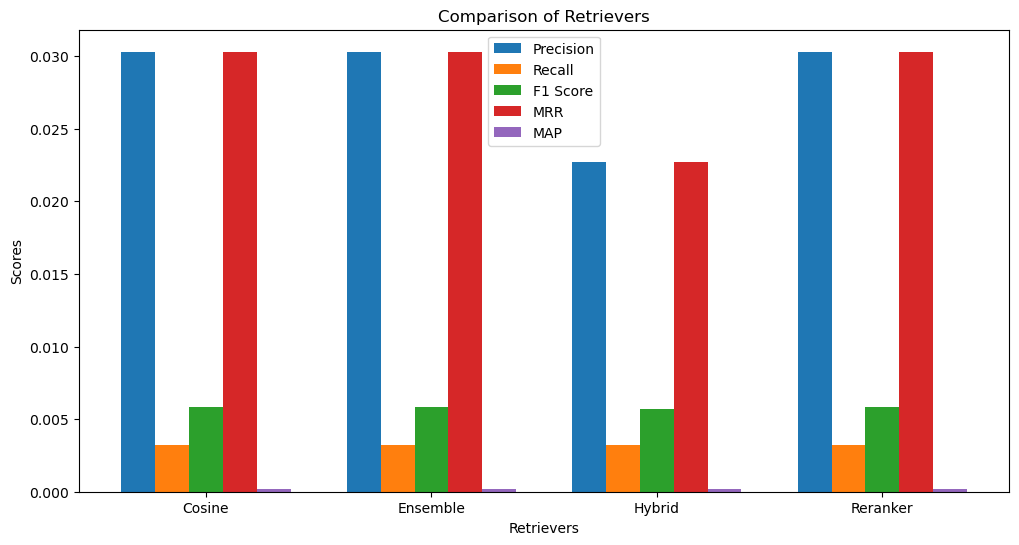

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
retrievers = ["Cosine", "Ensemble", "Hybrid", "Reranker"]
precision = [cosine_results["precision"], ensemble_results["precision"], hybrid_results["precision"], reranker_results["precision"]]
recall = [cosine_results["recall"], ensemble_results["recall"], hybrid_results["recall"], reranker_results["recall"]]
f1 = [cosine_results["f1_score"], ensemble_results["f1_score"], hybrid_results["f1_score"], reranker_results["f1_score"]]
mrr = [cosine_results["mrr"], ensemble_results["mrr"], hybrid_results["mrr"], reranker_results["mrr"]]
map = [cosine_results["map"], ensemble_results["map"], hybrid_results["map"], reranker_results["map"]]

# Plotting
x = np.arange(len(retrievers))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 2 * width, precision, width, label="Precision")
ax.bar(x - width, recall, width, label="Recall")
ax.bar(x, f1, width, label="F1 Score")
ax.bar(x + width, mrr, width, label="MRR")
ax.bar(x + 2 * width, map, width, label="MAP")

ax.set_xlabel("Retrievers")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Retrievers")
ax.set_xticks(x)
ax.set_xticklabels(retrievers)
ax.legend()

plt.show()

In [141]:
from langchain.chat_models import ChatOpenAI

# Initialize the LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)  # Use GPT-4 or GPT-3.5

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

# Formatting function for retrieved documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create prompt template
prompt_template = ChatPromptTemplate.from_template(
    """Answer the question based only on the following context:
    {context}
    
    Question: {question}
    
    Answer in a clear, scholarly style. If you don't know the answer, say 'I don't know'."""
)


# Create a similarity-based retriever
similarity_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# 3. Create RAG chain ---------------------------------------------------------

qa_rag_chain = (
    {
        "context": similarity_retriever | format_docs,
        "question": RunnablePassthrough() 
    }
    | prompt_template
    | llm
    | StrOutputParser()
)



In [105]:
# 4. Test the chain -----------------------------------------------------------
query = "Explain the key innovations in the Transformer architecture."
response = qa_rag_chain.invoke(query)
print(response)

The key innovation in the Transformer architecture lies in its reliance on self-attention mechanisms for computing representations of input and output sequences, without the need for traditional sequence-aligned recurrent neural networks (RNNs) or convolutional layers. This departure from recurrent structures allows for more efficient parallelization and the ability to model dependencies between elements in the input and output sequences regardless of their distance from each other. By utilizing stacked self-attention and point-wise fully connected layers in both the encoder and decoder, the Transformer is able to capture global dependencies and achieve state-of-the-art performance in tasks such as translation with significantly reduced training time. This novel approach to sequence transduction models represents a significant advancement in the field of neural network architectures.


Further Updates 

## RAG 


In [112]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

def format_docs_with_sources(docs):
    formatted_docs = []
    for doc in docs:
        source = doc.metadata.get('source', 'Unknown source')
        content = doc.page_content
        formatted_docs.append(f"Source: {source}\n\n{content}")
    return "\n\n".join(formatted_docs)

def get_top_sources(docs):
    sources = []
    for doc in docs:
        source = doc.metadata.get('source', 'Unknown source')
        content = doc.page_content
        sources.append({"source": source, "content": content})
    return sources

qa_chain_with_sources = (
    RunnableParallel(
        {
            "docs": similarity_retriever,  # Retrieve documents
            "question": RunnablePassthrough()  # Pass through the query
        }
    )
    | {
        "context": lambda x: format_docs_with_sources(x["docs"][:3]),  # Format top 3 docs
        "sources": lambda x: get_top_sources(x["docs"]),  # Extract sources
        "question": lambda x: x["question"]  # Pass through the query
    }
    | {
        "response": prompt_template | llm,  # Generate response
        "sources": lambda x: x["sources"]  # Pass through sources
    }
)

# 3. Test function with source display ----------------------------------------

def test_rag(query):
    # Invoke the RAG pipeline
    result = qa_chain_with_sources.invoke(query)
    
    # Extract the response and sources
    response = result["response"].content  # Extract the LLM's response
    sources = result["sources"]
    
    # Display results
    print("=== Query ===")
    print(query)
    print("\n=== Generated Answer ===")
    print(response)
    print("\n=== Top 3 Source Documents ===")
    for i, source in enumerate(sources, 1):
        print(f"Source {i} (Page {source['source']}):")
        print(source["content"][:500] + "...")  # Show first 500 characters
        print("-" * 80)

# 4. Sample queries to test ---------------------------------------------------

test_queries = [
    "What is the key innovation in the Transformer architecture?",
    "How does Mistral's approach differ from GPT-4?",
    "Explain the main contributions of the Attention is All You Need paper.",
    "What safety measures were implemented in InstructGPT?"
]

# 5. Run tests ---------------------------------------------------------------
for query in test_queries:
    test_rag(query)
    print("\n" + "="*100 + "\n")

=== Query ===
What is the key innovation in the Transformer architecture?

=== Generated Answer ===
The key innovation in the Transformer architecture is its reliance entirely on self-attention to compute representations of input and output, without the use of sequence-aligned recurrent neural networks (RNNs) or convolution. This departure from traditional models allows the Transformer to draw global dependencies between input and output, enabling significantly more parallelization and leading to improved translation quality. The Transformer's ability to model dependencies without regard to their distance in input or output sequences sets it apart from other models that typically use attention mechanisms in conjunction with recurrent networks.

=== Top 3 Source Documents ===
Source 1 (Page page_168):
Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder a

In [118]:
query = "Describe about the  topics we have discussed so far from the above given quereis "
response = qa_chain_with_sources.invoke(query)
print(response)

{'response': AIMessage(content='The topics discussed so far in the provided context include the composition of the dataset used in the study, the distribution of use-case categories for API prompts, the tasks involved in the evaluation process such as collecting metadata and conducting evaluations on public NLP datasets, and examples of challenges faced by the model in certain tasks. Additionally, the context mentions the release of samples from the models on sampling-based NLP tasks and the experimental evidence provided for the claims made in the study.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 552, 'total_tokens': 646, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id

Here the qa_chain_with_sources cannot give appropiate answer to the question in the above query , so the problem is with no information of the previous 
converation RAG history .

In [120]:
# Update the prompt template to include chat history
prompt_template_with_history = ChatPromptTemplate.from_template(
    """You are a helpful assistant. Use the following context and chat history to answer the user's query.
    
    Chat History:
    {chat_history}
    
    Context:
    {context}
    
    Question: {question}
    
    Answer in a clear, scholarly style. If you don't know the answer, say 'I don't know'."""
)

In [121]:
from langchain.memory import ConversationBufferMemory

# Initialize conversation memory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Update the RAG pipeline
qa_enhanced_chain_with_memory = (
    {
        "context": similarity_retriever | format_docs_with_sources,
        "question": RunnablePassthrough(),
        "chat_history": lambda x: memory.load_memory_variables({})["chat_history"]
    }
    | prompt_template_with_history
    | llm
    | StrOutputParser()
)

In [122]:
def ask_with_memory(query):
    # Invoke the RAG pipeline
    response = qa_enhanced_chain_with_memory.invoke(query)
    
    # Save the query and response to memory
    memory.save_context({"input": query}, {"output": response})
    
    return response

In [123]:
# Example queries
queries = [
    "What is the key innovation in the Transformer architecture?",
    "How does Mistral's approach differ from GPT-4?",
    "Explain the main contributions of the Attention is All You Need paper."
]

# Ask the queries and track history
for query in queries:
    response = ask_with_memory(query)
    print(f"Query: {query}")
    print(f"Response: {response}")
    print("-" * 80)


Query: What is the key innovation in the Transformer architecture?
Response: The key innovation in the Transformer architecture is its reliance entirely on self-attention to compute representations of input and output sequences, without the use of traditional sequence-aligned recurrent neural networks (RNNs) or convolutional layers. This departure from recurrent structures allows the Transformer to capture global dependencies between elements in the input and output sequences, enabling more efficient parallelization and achieving state-of-the-art performance in tasks such as translation. By utilizing self-attention mechanisms, the Transformer model can effectively model dependencies regardless of their distance in the sequences, leading to improved results and faster training times compared to traditional models that rely on recurrent connections.
--------------------------------------------------------------------------------
Query: How does Mistral's approach differ from GPT-4?
Respo

In [126]:

# Ask for a summary of previous queries
summary_query = "Give a summary of what is discussed so far in previous queries in 3 short points "
summary_response = ask_with_memory(summary_query)
print(f"Summary Query: {summary_query}")
print(f"Summary Response: {summary_response}")

Summary Query: Give a summary of what is discussed so far in previous queries in 3 short points 
Summary Response: The previous queries discussed the key innovation in the Transformer architecture, the comparison between Mistral's approach and GPT-4, and the main contributions of the "Attention is All You Need" paper. These topics highlighted the use of self-attention mechanisms, fine-tuning strategies, and advancements in natural language processing tasks.


## Multi-user conversational RAG system.

In [316]:
# In your retriever setup:
similarity_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5},
    # Add input formatter
    input_formatter=lambda x: x if isinstance(x, str) else x["text"]
)

In [421]:
from langchain.memory import ConversationBufferMemory

# Dictionary to store memory for each user
user_memories = {}

def get_user_memory(user_id):
    """Get or create a memory instance for a user."""
    if user_id not in user_memories:
        user_memories[user_id] = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    return user_memories[user_id]

In [434]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser




# prompt = """You are an assistant for Research question-answering tasks.
# Use the following pieces of retrieved context to answer the question.
# Do not make up the answer unless it is provided in the context.
# After answering, include a separate section titled "Sources" that lists the first three sources (as provided in the context).

# Question:
# {question}

# Context:
# {context}

# Chat History:
# {chat_history}

# Answer (Include inline citations like [Source 1]):
# """


prompt = """You are a conversational assistant for research Q&A. 
Use the following elements:
1. Retrieved context
2. Chat history
3. Current question

Chat History:
{chat_history}

Context:
{context}

Current Question:
{question}

Guidelines:
- Acknowledge previous discussions when relevant
- If asking follow-ups, keep them concise
- Cite sources like [Source 1] when using context
- If unsure, say so and suggest web search

Answer:
"""

prompt_template = ChatPromptTemplate.from_template(prompt)

def format_docs_with_sources(docs):
    formatted_sources = []
    for idx, doc in enumerate(docs[:3]):  # Limit to the first 3 sources
        source_name = doc.metadata.get("source", "Unknown Source")  # Get source from metadata
        page_number = doc.metadata.get("page", "?")  # If page info exists
        content_excerpt = doc.page_content[:300] if hasattr(doc, "page_content") else "No content available"
        
        formatted_sources.append(f"Source {idx+1} (Page {page_number}, {source_name}): {content_excerpt}...")

    return "\n".join(formatted_sources)




def get_rag_pipeline(user_id):
    """Get a RAG pipeline for a specific user."""
    memory = get_user_memory(user_id)
    
    return (
        RunnableParallel(
            {
                "context": similarity_retriever | format_docs_with_sources,
                "question": RunnablePassthrough(),
                "chat_history": lambda x: memory.load_memory_variables({})["chat_history"]
            }
        )
        | prompt_template_with_history
        | llm
        | StrOutputParser()
    )

In [320]:
query = "EXPLAIN ABOUT THE GEMINI MODEL?"
top3_docs = similarity_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

The Gemini model is a family of highly capable multimodal models designed to handle a variety of tasks involving both text and images. These models are built on top of Transformer decoders, which have been enhanced with architectural and optimization improvements to ensure stable training at scale and optimized inference, particularly on Google's Tensor Processing Units. The Gemini models are trained to support a context length of 32k, allowing them to process large amounts of data efficiently.

The Gemini models are natively multimodal, meaning they can seamlessly integrate and process information across different modalities, such as text, images, and even video. This capability allows them to perform tasks like extracting information from tables, charts, and figures, and applying strong reasoning skills typical of language models. They excel in tasks that require understanding and aggregating context across space and time, such as analyzing sequences of video frames or audio inputs.


In [321]:
def ask_with_memory(user_id, query):
    # Get the RAG pipeline for the user
    rag_pipeline = get_rag_pipeline(user_id)
    
    # Invoke the RAG pipeline and consume the generator
    response_generator = rag_pipeline.invoke(query)
    
    # Save the query and response to the user's memory
    memory = get_user_memory(user_id)
    memory.save_context({"input": query}, {"output": response_generator})
    
    return response

In [254]:
# User 1 queries
user1_id = "user_123"
queries_user1 = [
    "What is the key innovation in the Transformer architecture?",
    "How does Mistral's approach differ from GPT-4?"
]

# User 2 queries
user2_id = "user_456"
queries_user2 = [
    "Explain the main contributions of the Attention is All You Need paper.",
    "What safety measures were implemented in InstructGPT?"
]

# Ask queries for User 1
print("=== User 1 ===")
for query in queries_user1:
    response = ask_with_memory(user1_id, query)
    print(f"Query: {query}")
    print(f"Response: {response}")
    print("-" * 80)

# Ask queries for User 2
print("=== User 2 ===")
for query in queries_user2:
    response = ask_with_memory(user2_id, query)
    print(f"Query: {query}")
    print(f"Response: {response}")
    print("-" * 80)

=== User 1 ===
Query: What is the key innovation in the Transformer architecture?
Response: {'user_id': 'user_123', 'question': 'tell me the key aspects of the mistral AI paper ?', 'documents': [Document(metadata={'source': 'page_20'}, page_content='Figure 5: Results on MMLU, commonsense reasoning, world knowledge and reading comprehension for\nMistral 7B and Llama 2 (7B/13B/70B). Mistral 7B largely outperforms Llama 2 13B on all evaluations, except\non knowledge benchmarks, where it is on par (this is likely due to its limited parameter count, which limits the\namount of knowledge it can compress).\n5 Adding guardrails for front-facing applications\nThe ability to enforce guardrails when it comes to AI generation is important for front-facing appli-\ncations. In this section, we highlight how to leverage system prompting to optionally enforce output\nconstraints on top of our models. Additionally, we showcase the ability of Mistral 7B to perform'), Document(metadata={'source': 'page_2

In [234]:
# Ask for summaries for each user
summary_query = "Give a summary of what is discussed so far in previous queries"

print("=== User 1 Summary ===")
summary_response_user1 = ask_with_memory(user1_id, summary_query)
print(summary_response_user1)

print("=== User 2 Summary ===")
summary_response_user2 = ask_with_memory(user2_id, summary_query)
print(summary_response_user2)

=== User 1 Summary ===
The safety measures implemented in InstructGPT include significant enhancements aimed at mitigating potential risks associated with the model's responses. These measures include a reduction of the model's tendency to generate disallowed content by 82% compared to previous versions. Additionally, InstructGPT has shown an increased adherence to policies regarding sensitive requests like medical advice and self-harm by 29%. Furthermore, the model has demonstrated a substantial decrease in producing toxic content, with only 0.73% of generations being classified as toxic, compared to 6.48% in previous versions. To address potential risks related to bias, disinformation, over-reliance, privacy, cybersecurity, and proliferation, InstructGPT has implemented adversarial testing with domain experts and a model-assisted safety pipeline. These safety enhancements aim to ensure that the model's responses align more closely with ethical guidelines and societal norms, thereby r

## Agentic Corrective RAG patterns

In [156]:
!pip install langgraph

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [149]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

In [150]:
import os
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Tool -Tavily API 

In [385]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

In [386]:

# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)
# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())



In [387]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.5)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

## Building Agentic RAG Components 

In [389]:
from typing import List, Optional  # Import Optional
from typing_extensions import TypedDict
from typing import Annotated #Import Annotated

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        user_id: user id
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """
    user_id: str
    question: str
    documents: Optional[List[str]] # Optional should also have the type of the list
    chat_history: Annotated[Optional[list], "chat_history"]  # Track conversation history
    generation: str
    web_search_needed: str
    documents: List[str] #This line is duplicate and can be removed


In [416]:


# ====== Node Definitions ======
def retrieve(state: GraphState):
    """Retrieve documents with user-aware context"""
    print("---RETRIEVE---")
    user_id = state["user_id"]
    question = state["question"]
    
    # Ensure the question is a string
    if not isinstance(question, str):
        raise TypeError(f"Expected 'question' to be a string, but got {type(question)}: {question}")
    
    # Get user-specific memory
    memory = get_user_memory(user_id)
    
    # Retrieve documents (modified to use your existing retriever)
    documents = similarity_retriever.invoke(question)  # Pass the plain text question
    
    return {
        **state,
        "documents": documents,
        "chat_history": memory.load_memory_variables({})["chat_history"]
    }

In [417]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

In [418]:
# Rewrite query

# This will be used to rewrite the input query to produce a better question optimized for web search using an LLM

def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

    rewritten_query = response_state.get("rewritten_query", query)
    print(f"Final Query Used: {rewritten_query}")

In [397]:
# Web Search

# This will be used to search the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG


from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [431]:

from langchain.schema import HumanMessage, AIMessage

def format_chat_history(chat_history):
    """Convert chat history into a formatted string with role labels."""
    if not chat_history:
        return "No chat history yet."
    
    formatted = []
    for msg in chat_history:
        if isinstance(msg, HumanMessage):
            formatted.append(f"User: {msg.content}")
        elif isinstance(msg, AIMessage):
            formatted.append(f"Assistant: {msg.content}")
        elif isinstance(msg, dict):
            # Handle dictionary format
            role = msg.get("role", "Unknown")
            content = msg.get("content", "")
            formatted.append(f"{role.capitalize()}: {content}")
        else:
            formatted.append(str(msg))
            
    return "\n".join(formatted)

In [420]:


def get_rag_pipeline(user_id):
    """Get a RAG pipeline for a specific user."""
    memory = get_user_memory(user_id)
    
    return (
        RunnableParallel(
            {
                # Extract the question string before passing to similarity_retriever
                "context": (lambda inp: inp["question"]) | similarity_retriever | format_docs_with_sources,
                "question": RunnablePassthrough(),
                "chat_history": lambda x: format_chat_history(memory.load_memory_variables({})["chat_history"])
            }
        )
        | prompt_template_with_history  # Ensure this is defined; if not, use prompt_template
        | llm
        | StrOutputParser()
    )



In [406]:


def generate_answer(state: GraphState):
    """Use your existing multi-user RAG pipeline for generation"""
    print("---GENERATE ANSWER---")
    user_id = state["user_id"]
    question = state["question"]
    documents = state["documents"]
    
    # Get user-specific RAG pipeline
    rag_pipeline = get_rag_pipeline(user_id)
    
    # Format input for your existing pipeline
    inputs = {
        "question": question,  # Pass the plain text question
        "context": format_docs_with_sources(documents),
        # "chat_history": state["chat_history"]
        "chat_history": format_chat_history(state["chat_history"])
    }
    
    # Generate response using your existing flow
    response = rag_pipeline.invoke(inputs)
    
    # Update memory
    memory = get_user_memory(user_id)
    memory.save_context({"input": question}, {"output": response})
    
    return {
        **state,
        "generation": response,
        "chat_history": memory.load_memory_variables({})["chat_history"]
    }

In [423]:


#Decide to Generate

# This will be used as a conditional function which will check the web_search_needed flag and
# decide if a web search is needed or a response should be generated and return the function name to be called

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

In [159]:
%pip install langgraph

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [415]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

#Modified node list
agentic_rag.add_node("retrieve", retrieve)
agentic_rag.add_node("grade_documents", grade_documents)
agentic_rag.add_node("rewrite_query", rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer", generate_answer)  # Now uses your RAG pipeline

# Edge setup remains similar but now handles user-aware state
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile graph
agentic_rag = agentic_rag.compile()

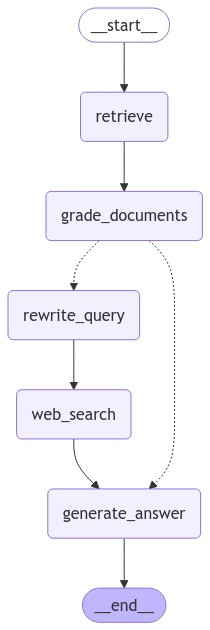

In [411]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [449]:
def is_meta_query(query, chat_history):
    """Detect questions about conversation history"""
    meta_keywords = [
        "discussed so far", 
        "previous questions",
        "conversation history",
        "what we talked about"
    ]
    return any(kw in query.lower() for kw in meta_keywords)

def handle_meta_query(query, chat_history):
    """Generate response for history-related queries"""
    if not chat_history:
        return "We haven't discussed anything yet. Feel free to ask your first question!"
    
    # Format history into bullet points
    summary = "Here's our discussion so far:\n" + "\n".join(
        f"- {msg.content}" for msg in chat_history if isinstance(msg, (HumanMessage, AIMessage))
    )
    
    return summary

In [448]:

def get_answer(user_id, query):
    """Get answer with conversation context"""
    memory = get_user_memory(user_id)
    chat_history = memory.load_memory_variables({}).get("chat_history", [])
    
    # Handle meta-queries first
    if is_meta_query(query, chat_history):
        return handle_meta_query(query, chat_history), "No sources - meta-query"
    
    # Invoke pipeline with current state
    response_state = agentic_rag.invoke({
        "user_id": user_id,
        "question": query,
        "documents": [],
        "generation": "",
        "web_search_needed": "No",
        "chat_history": chat_history  # Pass existing history
    })
    
    # Update memory with new interaction
    memory.save_context(
        {"input": query},
        {"output": response_state["generation"]}
    )
    
    return response_state["generation"], format_docs_with_sources(response_state["documents"])



In [427]:
# Example Usage:
user_id = "user_123"
query = "tell me the key aspects of the Mistral AI paper?"
answer, sources = get_answer(user_id, query)


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [430]:
print("\nAnswer:\n", answer)
print("\nSources:\n", sources)


Answer:
 The key aspects of the Mistral AI paper include its superior performance on various language understanding tasks compared to the Llama 2 model, its ability to compress knowledge effectively, and its release under the Apache 2.0 license with a reference implementation for easy deployment on cloud platforms. Mistral 7B showcases the potential for language models to efficiently handle complex tasks while also providing accessibility and integration options for users.

Sources:
 Source 1 (Page ?, page_20): Figure 5: Results on MMLU, commonsense reasoning, world knowledge and reading comprehension for
Mistral 7B and Llama 2 (7B/13B/70B). Mistral 7B largely outperforms Llama 2 13B on all evaluations, except
on knowledge benchmarks, where it is on par (this is likely due to its limited parameter count, w...
Source 2 (Page ?, page_27): Our work on Mistral 7B demonstrates that language models may compress knowledge more than
what was previously thought. This opens up interesting persp

In [447]:

def chat_interface(user_id):
    """Multi-turn conversation interface with new user handling"""
    print("Welcome to the Agentic RAG Chat!\nType 'exit' to end the conversation.\n")
    
    # Initialize memory for new users
    memory = get_user_memory(user_id)
    chat_history = memory.load_memory_variables({}).get("chat_history", [])
    
    while True:
        try:
            query = input("You: ")
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break
            
        if query.lower() in ["exit", "quit"]:
            print("Ending conversation...")
            break
            
        # Handle empty history explicitly
        if not chat_history:
            if "discussed" in query.lower() or "previous" in query.lower():
                print("\nAssistant: We haven't discussed anything yet. Please ask your first question!")
                print("="*80 + "\n")
                continue
                
        # Get response
        answer, sources = get_answer(user_id, query)
        
        # Update local chat history reference
        chat_history = memory.load_memory_variables({}).get("chat_history", [])
        
        # Display response
        print("\nAssistant:")
        print(answer)
        if "no sources were retrieved" not in sources.lower():
            print("\nSources:")
            print(sources)
        print("\n" + "="*80 + "\n")


In [437]:
def needs_clarification(query, chat_history):
    # Add logic to detect ambiguous terms
    ambiguous_terms = ["it", "they", "this"]
    return any(term in query.lower() for term in ambiguous_terms)

In [436]:
from datetime import datetime

conversation_states = {}  # Track last activity time

def check_timeout(user_id):
    last_active = conversation_states.get(user_id, datetime.now())
    return (datetime.now() - last_active).seconds > 300  # 5-minute timeout

In [439]:
# Start conversation
user_id = "mani"
chat_interface(user_id)

Welcome to the Agentic RAG Chat!
Type 'exit' to end the conversation.

who are the author of attention is all you need paper
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---

Assistant:
The authors of the research paper titled "Attention is All You Need" are Ashish Vaswani, Noam Shazeer, and Niki Par.

Sources:
Source 1 (Page ?, page_156): Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Par...
Source 2 (P

In [440]:
# Start conversation
user_id = "mani"
chat_interface(user_id)

---GRADE: DOCUMENT NOT RELEVANT---Welcome to the Agentic RAG Chat!
Type 'exit' to end the conversation.

give me a summary of what we have discussed so far ? 
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---

Assistant:
The key points covered in our discussion so far include the authors of the research paper titled "Attention is All You Need" - Ashish Vaswani, Noam Shazeer, and Niki Par. The paper introduces the Transformer model, a neural network architecture that relies solely on attention mechanisms without recurrent or convolutional layers. This innovative design has revolutionized natural language processing tasks by achieving state-of-the-

In [451]:
# Start conversation
user_id = "sruh"
chat_interface(user_id)

Welcome to the Agentic RAG Chat!
Type 'exit' to end the conversation.


Assistant: We haven't discussed anything yet. Please ask your first question!

Ending conversation...


In [452]:
# Start conversation
user_id = "bobby"
chat_interface(user_id)

Welcome to the Agentic RAG Chat!
Type 'exit' to end the conversation.

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---

Assistant:
InstructGPT is an enhanced version of the GPT model that has shown improvements in truthfulness and informativeness compared to GPT-3. InstructGPT models, specifically the PPO-ptx models, have been found to generate truthful and informative answers about twice as often as GPT-3 on the TruthfulQA benchmark. Additionally, when directly compared, outputs from InstructGPT are preferred over GPT-3 outputs 85% of the time and preferred over few-shot GPT-3 outputs 71% of the time. This indicates that InstructGPT excels in producing more accurate and reliable responses compared to the standard GPT model.

Sources:
Sour

In [453]:
# Start conversation
user_id = "bobby"
chat_interface(user_id)

Welcome to the Agentic RAG Chat!
Type 'exit' to end the conversation.

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---

Assistant:
The Mistral model, particularly the Mistral 7B – Instruct variant, has demonstrated superior performance in comparison to other models in various benchmarks. Specifically, Mistral 7B – Instruct has shown to outperform all 7B models on the MT-Bench and is comparable to 13B – Chat models in terms of performance. This indicates that the Mistral model, especially the Instruct version, excels in delivering high-level performance and achieving competitive results in comparison to other models of similar or larger sizes. Additionally, Mistral 7B has been shown to outperform Llama 2 13B on all metrics, showcasing its e